In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arms
%matplotlib inline

# Stochastic Multi-Armed Bandits on Simulated Data

## Bernoulli bandit models

We consider the following 4 arms multi-armed bandit model:
$$
r_1 \sim \mathcal{B}(0.3)\\
r_2 \sim \mathcal{B}(0.25)\\
r_3 \sim \mathcal{B}(0.20)\\
r_4 \sim \mathcal{B}(0.10)
$$
We simulate the bandit game using the following algorithms: UCB, Thompson sampling, naive approach, and  generalized Thompson, and we plot the cumulative regret

In [2]:
class MAB:
    
    def __init__(self, arms):
        
        """
        Description
        -------------
        Constructor of class MAB
        
        Attributes
        -------------
        arms    : list of arms.
        nb_arms : Int, number of arms.
        means   : List, means of the arms.
        
        Returns
        -------------
        """
        
        self.arms = arms
        self.nb_arms = len(arms)
        self.means = [el.mean for el in arms]
        self.mu_max = np.max(self.means)
        self.arm_max = np.argmax(self.means)
        
    def kl(self, x, y):
        
        """
        Description
        -------------
        KL divergence with Bernoulli distributions
        
        Parameters
        -------------
        x, y : Floats in ]0, 1[
        
        Returns
        -------------
        KL divergence
        """
        return x*np.log(x/y) + (1 - x)*np.log((1 - x)/(1 - y))
    
    def C(self):
        
        """
        Description
        -------------
        Compute the complexity of the Lai and Robbins lower bound.
        
        Parameters
        -------------
        
        Returns
        -------------
        C(p)
        """
        
        means_inf = self.means.copy()
        means_inf.remove(self.mu_max)
        means_inf = np.array(means_inf)
        return np.sum((self.mu_max - means_inf)/self.kl(means_inf, self.mu_max))
        
    
    def UCB1(self, T):
        
        """
        Description
        -------------
        Simulate a bandit game of length T with the upper-confidence bound algorithm on the bandit 
        model MAB
        
        Parameters
        -------------
        T : Int, the length of the bandit game we simulate.
        
        Returns
        -------------
        rew   : np.array of length T, sequence of the T rewards obtained.
        draws : np.array of length T, sequence of the T arms drawn.
        """
        
        # Gather the number of times each arm is pulled in n_draws and the sum of the rewards in s_rewards
        K = len(self.arms)
        assert (T >= K), "T < number of arms!"
        rew, draws = np.zeros(T), np.zeros(T)
        # Initialization
        s_rewards = np.zeros(K)
        n_draws = np.ones(K)
        for t in range(len(self.arms)):
            rew[t] = self.arms[t].sample()
            draws[t] = t
            s_rewards[t] = rew[t]
            
        for t in range(len(self.arms), T):
            scores = s_rewards/n_draws + 0.2*np.sqrt(np.log(t)/(2*n_draws))
            a = np.argmax(scores)
#             if t % 1000 == 0:
#                 print(0.2*np.sqrt(np.log(t)/(2*n_draws[a])))
            draws[t] = a
            n_draws[a] += 1
            rew[t] = self.arms[a].sample()
            s_rewards[a] += rew[t]
            
        return rew, draws
    
    def TS(self, T):
        
        """
        Description
        -------------
        Simulate a bandit game of length T with Thompson sampling on the bandit model MAB
        
        Parameters
        -------------
        T : Int, the length of the bandit game we simulate.
        
        Returns
        -------------
        rew   : np.array of length T, sequence of the T rewards obtained.
        draws : np.array of length T, sequence of the T arms drawn.
        """
        
        # Gather the number of times each arm is pulled in n_draws and the sum of the rewards in s_rewards
        K = len(self.arms)
        assert (T >= K), "T < number of arms!"
        rew, draws = np.zeros(T), np.zeros(T)
        s_rewards, n_draws = np.zeros(K), np.zeros(K)
        for t in range(T):
            thetas = np.zeros(K)
            for a in range(K):
                thetas[a] = np.random.beta(s_rewards[a] + 1, n_draws[a] - s_rewards[a] + 1)
                
            a = np.argmax(thetas)
            draws[t] = a
            n_draws[a] += 1
            rew[t] = self.arms[a].sample()
            s_rewards[a] += rew[t]
            
        return rew, draws
    
    def naive(self, T):
        
        """
        Description
        -------------
        Perform naive strategy that selects the empirical best arm at each round.
        
        Parameters
        -------------
        T : Int, the length of the bandit game we simulate.
        
        Returns
        -------------
        rew   : np.array of length T, sequence of the T rewards obtained.
        draws : np.array of length T, sequence of the T arms drawn.
        """
        
        # Gather the number of times each arm is pulled in n_draws and the sum of the rewards in s_rewards
        K = len(self.arms)
        assert (T >= K), "T < number of arms!"
        rew, draws = np.zeros(T), np.zeros(T)
        s_rewards, n_draws = np.zeros(K), np.zeros(K)
        # Initialization
        s_rewards = np.zeros(K)
        n_draws = np.ones(K)
        for t in range(len(self.arms)):
            rew[t] = self.arms[t].sample()
            draws[t] = t
            s_rewards[t] = rew[t]
            
        for t in range(len(self.arms), T):
            scores = s_rewards/n_draws
            a = np.argmax(scores)
            draws[t] = a
            n_draws[a] += 1
            rew[t] = self.arms[a].sample()
            s_rewards[a] += rew[t]
            
        return rew, draws
    
    def TS_generalized(self, T):
        
        """
        Description
        -------------
        Simulate a bandit game of length T with Thompson sampling on the bandit model MAB
        
        Parameters
        -------------
        T : Int, the length of the bandit game we simulate.
        
        Returns
        -------------
        rew   : np.array of length T, sequence of the T rewards obtained.
        draws : np.array of length T, sequence of the T arms drawn.
        """
        
        # Gather the number of times each arm is pulled in n_draws and the sum of the rewards in s_rewards
        K = len(self.arms)
        assert (T >= K), "T < number of arms!"
        rew, draws = np.zeros(T), np.zeros(T)
        s_rewards, n_draws = np.zeros(K), np.zeros(K)
        for t in range(T):
            thetas = np.zeros(K)
            for a in range(K):
                thetas[a] = np.random.beta(s_rewards[a] + 1, n_draws[a] - s_rewards[a] + 1)
                
            a = np.argmax(thetas)
            draws[t] = a
            n_draws[a] += 1
            rew_proba = self.arms[a].sample() # Bernoulli success probability
            rew[t] = np.random.binomial(1, rew_proba)
            s_rewards[a] += rew[t]
            
        return rew, draws
    
    def plot_reg(self, T, n_sim = 100, algos = ['UCB', 'Thompson', 'Naive']):
        
        """
        Description
        -------------
        Display regret curves
        
        Parameters
        -------------
        T     : Int, the length of the bandit game we simulate
        n_sim : Int, the number of bandit games to mean
        algos : List of strings, plot the regret curves of these algorithms
        
        Returns
        -------------
        """
        
        C = self.C()
        plt.figure(1)
        x = np.arange(1, T+1)
        if 'UCB' in algos:
            rew1, draws1, reg1 = np.zeros(T), np.zeros(T), np.zeros(T)
            for i in range(n_sim):
                rew, draws = self.UCB1(T)
                rew1 += rew
                draws1 += draws
                reg1 += self.mu_max * np.arange(1, T + 1) - np.cumsum(rew)
                
            reg1 /= n_sim
            plt.plot(x, reg1, label = 'UCB')
            
        if 'Thompson' in algos:
            rew2, draws2, reg2 = np.zeros(T), np.zeros(T), np.zeros(T)
            for i in range(n_sim):
                rew, draws = self.TS(T)
                rew2 += rew
                draws2 += draws
                reg2 = self.mu_max * np.arange(1, T + 1) - np.cumsum(rew)
                
            reg2 /= n_sim
            plt.plot(x, reg2, label = 'Thompson')
            
        if 'Naive' in algos:
            rew3, draws3, reg3 = np.zeros(T), np.zeros(T), np.zeros(T)
            for i in range(n_sim):
                rew, draws = self.naive(T)
                rew3 += rew
                draws3 += draws
                reg3 = self.mu_max * np.arange(1, T + 1) - np.cumsum(rew)
                
            reg3 /= n_sim
            plt.plot(x, reg3, label = 'Naive')
            
        if 'Thompson_generalized' in algos:
            rew4, draws4, reg4 = np.zeros(T), np.zeros(T), np.zeros(T)
            for i in range(n_sim):
                rew, draws = self.TS_generalized(T)
                rew4 += rew
                draws4 += draws
                reg4 = self.mu_max * np.arange(1, T + 1) - np.cumsum(rew)
                
            reg4 /= n_sim
            plt.plot(x, reg4, label = 'Thompson_generalized')
        
        plt.plot(x, C*np.log(x), label = 'Oracle')
        plt.xlabel('Rounds')
        plt.ylabel('Cumulative Regret')
        plt.legend()
        plt.show()

                

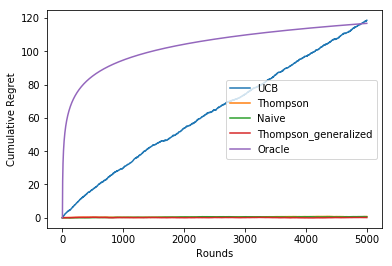

In [3]:
arm1 = arms.ArmBernoulli(0.30, random_state=np.random.randint(1, 312414))
arm2 = arms.ArmBernoulli(0.25, random_state=np.random.randint(1, 312414))
arm3 = arms.ArmBernoulli(0.20, random_state=np.random.randint(1, 312414))
arm4 = arms.ArmBernoulli(0.10, random_state=np.random.randint(1, 312414))

arms_list = [arm1, arm2, arm3, arm4]
mab = MAB(arms_list)

mab.plot_reg(5000, n_sim = 100, algos = ['UCB', 'Thompson', 'Naive', 'Thompson_generalized'])

## Non-parametric bandits (bounded rewards)

In the generalized Thompson sampling, we choose arm $i$ in the same way we did in Bernoulli bandit problem, however when sampling the arm, this time we get $\tilde{r}_t \in [0, 1]$ instead of $\{0, 1\}$ since We are no longer in a Bernoulli frame, thus we get the reward $r_t$ by sampling Bernoulli distribution $\mathcal{B}(\tilde{r}_t)$.

Here we cosnider the following arms:
$$
r_1 \sim \mathcal{B}(0.30)\\
r_2 \sim \mathcal{B}(0.25)\\
r_3 \sim \mathcal{Beta}(2, 5)\\
r_4 \sim \mathcal{Beta}(0.5, 0.5)\\
r_5 \sim \mathcal{E}(1)\\
r_6 \sim \mathcal{E}(1.5)
$$

according to [Burnetas and Katehakis, 1996], there are no parametric assumptions used in the demonstration of the oracle lower bound, thus the notion of complexity still makes sense.


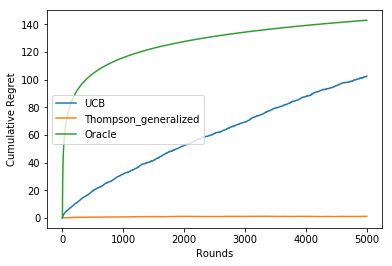

In [6]:
arm1 = arms.ArmBernoulli(0.30, random_state=np.random.randint(1, 312414))
arm2 = arms.ArmBernoulli(0.25, random_state=np.random.randint(1, 312414))
arm3 = arms.ArmBeta(2, 5, random_state=np.random.randint(1, 312414))
arm4 = arms.ArmBeta(0.5, 0.5, random_state=np.random.randint(1, 312414))
arm5 = arms.ArmExp(1, random_state=np.random.randint(1, 312414))
arm6 = arms.ArmExp(1.5, random_state=np.random.randint(1, 312414))

arms_list = [arm1, arm2, arm3, arm4, arm5, arm6]

mab = MAB(arms_list)

mab.plot_reg(5000, n_sim = 100, algos = ['Thompson_generalized', 'UCB'])

# Linear Bandit on Real Data

In [129]:
from tqdm import tqdm

class LinearMABModel(object):
    def __init__(self, random_state=0, noise=0.):
        self.local_random = np.random.RandomState(random_state)
        self.noise = noise

    def reward(self, action):
        assert 0<= action < self.n_actions, "{} not in 0 .. {}".format(action, self.n_actions)
        reward = np.dot(self.features[action], self.real_theta) + self.noise * self.local_random.randn(1)
        return reward

    def best_arm_reward(self):
        D = np.dot(self.features, self.real_theta)
        return np.max(D)

    @property
    def n_features(self):
        return self.features.shape[1]

    @property
    def n_actions(self):
        return self.features.shape[0]
    
    def LinUCB(self, T, lambd, alpha):
        
        """
        Description
        -------------
        Perform LinearUCB algorithm to estimate the real parameter.
        
        Parameters
        -------------
        T          : Int, the length of the linear bandit model we simulate.
        lambd      : Float, regularization parameter.
        alpha      : Float, parameter of the confidence interval.
        
        Returns
        -------------
        rewards : np.array of length T carrying the rewards at each iteration.
        thetas   : np.array of shape (T, n_features) carrying the estimated parameter at each iteration.
        actions : np.array of length T carrying the chosen actions at each iteration.
        """
        
        thetas = np.zeros((T, self.n_features))
        rewards = np.zeros(T)
        actions = np.zeros(T)
        A = lambd*np.eye(self.n_features) + np.dot(self.features[0].reshape((-1, 1)), self.features[0].reshape((1, -1)))
        b = self.reward(0)*self.features[0]
        confidence = np.zeros(self.n_actions)
            
        for t in range(T):
            inv_A = np.linalg.inv(A)
            theta = np.dot(inv_A, b)
            thetas[t, :] = theta
            for action in range(self.n_actions):
                phi_a = self.features[action]
                confidence[action] = alpha*np.sqrt(np.dot(phi_a.reshape((1, -1)), np.dot(inv_A, phi_a)))
                
            action = np.argmax(np.dot(self.features, theta) + confidence)
            actions[t] = action
            reward = np.dot(self.features[action], theta)
            rewards[t] = reward
            A += np.dot(self.features[action].reshape((-1, 1)), self.features[action].reshape((1, -1)))
            b += self.reward(action)*self.features[action]
            if t%100 == 0:
                alpha = alpha/(t + 1)**0.5
            
        return rewards, thetas, actions
    
    def random(self, T, lambd):
        
        """
        Description
        -------------
        Perform random policy to estimate theta.
        
        Parameters
        -------------
        T          : Int, the length of the linear bandit model we simulate.
        
        Returns
        -------------
        rewards : np.array of length T carrying the rewards at each iteration.
        theta   : np.array of length T carrying the estimated parameter at each iteration.
        """
        
        thetas = np.zeros((T, self.n_features))
        rewards = np.zeros(T)
        actions = np.zeros(T)
        A = lambd*np.eye(self.n_features) + np.dot(self.features[0].reshape((-1, 1)), self.features[0].reshape((1, -1)))
        b = self.reward(0)*self.features[0]
            
        for t in range(T):
            theta = np.dot(np.linalg.inv(A), b)
            thetas[t, :] = theta
            action = np.random.randint(0, self.n_actions)
            actions[t] = action
            reward = np.dot(self.features[action], theta)
            rewards[t] = reward
            A += np.dot(self.features[action].reshape((-1, 1)), self.features[action].reshape((1, -1)))
            b += self.reward(action)*self.features[action]
            
        return rewards, thetas, actions
    
    def greedy(self, T, epsilon, lambd):
        
        """
        Description
        -------------
        Perform epsilon-greedy policy to estimate theta.
        
        Parameters
        -------------
        T          : Int, the length of the linear bandit model we simulate.
        epsilon    : Float, the greedy policy probability.
        
        Returns
        -------------
        rewards : np.array of length T carrying the rewards at each iteration.
        theta   : np.array of length T carrying the estimated parameter at each iteration.
        """
        
        thetas = np.zeros((T, self.n_features))
        rewards = np.zeros(T)
        actions = np.zeros(T)
        A = lambd*np.eye(self.n_features) + np.dot(self.features[0].reshape((-1, 1)), self.features[0].reshape((1, -1)))
        b = self.reward(0)*self.features[0]
            
        for t in range(T):
            theta = np.dot(np.linalg.inv(A), b)
            thetas[t, :] = theta
            if np.random.binomial(1, 1 - epsilon) == 1:
                action = np.argmax(np.dot(self.features, theta))
                
            else:
                action = np.random.randint(0, self.n_actions)
                while action == np.argmax(np.dot(self.features, theta)):
                    action = np.random.randint(0, self.n_actions)
                    
            actions[t] = action
            reward = np.dot(self.features[action], theta)
            rewards[t] = reward
            A += np.dot(self.features[action].reshape((-1, 1)), self.features[action].reshape((1, -1)))
            b += self.reward(action)*self.features[action]
            
        return rewards, thetas, actions
    
    def plot_performance(self, T, nb_simu, lambd, alpha, epsilon = 0.1):
        
        """
        Description
        -------------
        Plot the performance of the model
        """
        
        regret1 = np.zeros((nb_simu, T))
        norm_dist1 = np.zeros((nb_simu, T))
        regret2 = np.zeros((nb_simu, T))
        norm_dist2 = np.zeros((nb_simu, T))
        regret3 = np.zeros((nb_simu, T))
        norm_dist3 = np.zeros((nb_simu, T))
        
        for k in tqdm(range(nb_simu), desc="Simulating {}".format('LinUCB')):
            rewards, theta, actions = model.LinUCB(T, lambd, alpha)
            regret1[k, :] = model.best_arm_reward() - np.vectorize(self.reward)(actions.astype(int))
            norm_dist1[k, :] = np.linalg.norm(theta - model.real_theta, 2, axis = 1)

        mean_norms1 = norm_dist1.mean(axis = 0)
        mean_regret1 = regret1.mean(axis = 0)
        
        for k in tqdm(range(nb_simu), desc="Simulating {}".format('random')):
            rewards, theta, actions = model.random(T, lambd)
            regret2[k, :] = model.best_arm_reward() - np.vectorize(self.reward)(actions.astype(int))
            norm_dist2[k, :] = np.linalg.norm(theta - model.real_theta, 2, axis = 1)

        mean_norms2 = norm_dist2.mean(axis = 0)
        mean_regret2 = regret2.mean(axis = 0)
        
        for k in tqdm(range(nb_simu), desc="Simulating {}".format('epsilon-greedy')):
            rewards, theta, actions = model.greedy(T, epsilon, lambd)
            regret3[k, :] = model.best_arm_reward() - np.vectorize(self.reward)(actions.astype(int))
            norm_dist3[k, :] = np.linalg.norm(theta - model.real_theta, 2, axis = 1)

        mean_norms3 = norm_dist3.mean(axis = 0)
        mean_regret3 = regret3.mean(axis = 0)
        

        plt.figure(1, figsize = (15, 8))
        plt.subplot(121)
        plt.plot(mean_norms1, label='LinUCB')
        plt.plot(mean_norms2, label='random')
        plt.plot(mean_norms3, label='eps-greedy')
        plt.ylabel('d(theta, theta_hat)')
        plt.xlabel('Rounds')
        plt.legend()

        plt.subplot(122)
        plt.plot(mean_regret1.cumsum(), label='LinUCB')
        plt.plot(mean_regret2.cumsum(), label='random')
        plt.plot(mean_regret3.cumsum(), label='eps-greedy')
        plt.ylabel('Cumulative Regret')
        plt.xlabel('Rounds')
        plt.legend()
        plt.show()


class ToyLinearModel(LinearMABModel):
    def __init__(self, n_features, n_actions, random_state=0, noise=0.):
        super(ToyLinearModel, self).__init__(random_state=random_state, noise=noise)

        self.features = self.local_random.rand(n_actions, n_features) - 0.5
        self.real_theta = self.local_random.rand(n_features) - 0.5


class ColdStartMovieLensModel(LinearMABModel):
    def __init__(self, random_state=0, noise=0.):

        self.features = np.loadtxt('movielens/Vt.csv', delimiter=',').T

        super(ColdStartMovieLensModel, self).__init__(random_state=random_state, noise=noise)

        self.real_theta = self.local_random.randn(self.n_features)

We use $\alpha = 100$ decaying every 10 iterations with a root squared decay, $\lambda = 0.01$ for the linear UCB and $\epsilon = 0.1$ for the $\epsilon-$greedy policy.

the random exploration and $\epsilon-$greedy policy give better estimates of $\theta$ than linear UCB, but they suffer more from cumulative regret.

## Toy Model

In [130]:
random_state = np.random.randint(0, 24532523)
model = ToyLinearModel(
    n_features=8,
    n_actions=20,
    random_state=random_state,
    noise=0.1)

In [131]:
n_a = model.n_actions
d = model.n_features

T = 6000
nb_simu = 10

Simulating epsilon-greedy: 100%|███████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


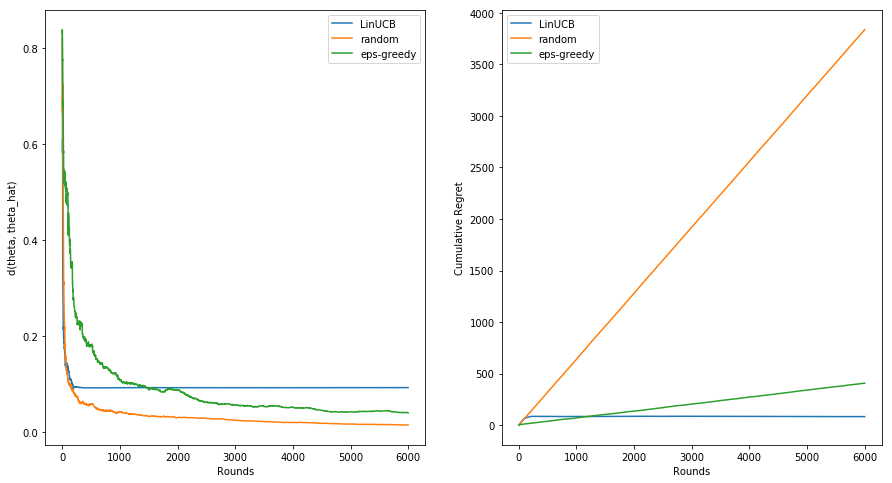

In [132]:
model.plot_performance(T, nb_simu,  lambd = 0.01, alpha = 50, epsilon = 0.1)

## Cold-Start Movie Lens Model

In [133]:
random_state = np.random.randint(0, 24532523)

model = ColdStartMovieLensModel(
    random_state=random_state,
    noise=0.1
)
n_a = model.n_actions
d = model.n_features

T = 6000
nb_simu = 10

Simulating epsilon-greedy: 100%|███████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.08it/s]


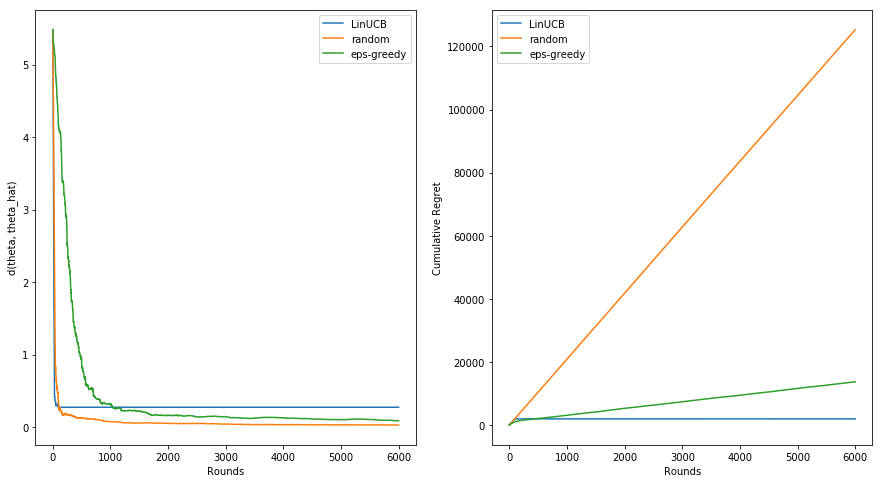

In [134]:
model.plot_performance(T, nb_simu,  lambd = 0.01, alpha = 100, epsilon = 0.1)